# Police Reform vs Abolition: A Number's Perspective
case study: New York City
## Nicole Pagane | June 2020
adaptation from Numerical Methods Final Project (and Compuational Sociology), May 2019

In [1]:
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pysal as ps
import re
from geopandas import GeoDataFrame
from shapely.geometry import Point
#from pysal.contrib.viz import mapping as maps
import scipy.stats as stats
from datetime import datetime as dt
import time
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (12.0, 12.0)
from matplotlib.colors import LogNorm
# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display
import warnings

/home/nicolepagane/anaconda3/envs/abolition/lib/python3.8/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/home/nicolepagane/anaconda3/envs/abolition/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
# read in files
nyc = gpd.read_file("census/nynta.shp") # neighborhood shape data
race =  pd.read_csv("census/RaceEthnic Change by Neighborhood 5-23-11.csv",skiprows=5,skipfooter=8) # race data

arrest = pd.read_csv("arrest/NYPD_Arrests_Data__Historic_.csv") # arrest data
codes = pd.read_csv("arrest/Key codes offense description.csv") # arrest codes

<ipython-input-2-979f022ee7b5>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  race =  pd.read_csv("census/RaceEthnic Change by Neighborhood 5-23-11.csv",skiprows=5,skipfooter=8) # race data


In [3]:
race = race.loc[np.isnan(race['Total'])== False]
race = race.rename(columns={'Unnamed: 0':'NTACode', 'White ':"White","Black ":"Black","Asian ":"Asian", "Latino ":"Latino"})
race.iloc[:,0] = race.iloc[:,0].str[:4]
race = race[['NTACode','Total', "White", "Black", "Latino","Asian", "Others"]]

In [4]:
for i in nyc['NTACode']:
    if i not in set(race['NTACode']): 
        print(i)
print('checked for overlap of neighborhood codes in shape and race file')

checked for overlap of neighborhood codes in shape and race file


In [5]:
# add race data to shape file
nyc = nyc.merge(race, on='NTACode')

In [6]:
codes = codes.loc[np.isnan(codes.iloc[:,0])==False]
for i in range(len(codes)):
    print(codes.iloc[i,0], '', codes.iloc[i,1])

101.0  MURDER & NON-NEGL. MANSLAUGHTER
102.0  HOMICIDE-NEGLIGENT-VEHICLE
103.0  HOMICIDE-NEGLIGENT, UNCLASSIFIED
104.0  RAPE
105.0  ROBBERY
106.0  FELONY ASSAULT
107.0  BURGLARY
109.0  GRAND LARCENY
110.0  GRAND LARCENY OF MOTOR VEHICLE
111.0  POSSESSION OF STOLEN PROPERTY
112.0  THEFT-FRAUD
113.0  FORGERY
114.0  ARSON
115.0  PROSTITUTION & RELATED OFFENSES
116.0  SEX CRIMES
117.0  DANGEROUS DRUGS
118.0  DANGEROUS WEAPONS
119.0  INTOXICATED/IMPAIRED DRIVING
120.0  CHILD ABANDONMENT/NON SUPPORT
120.0  ENDAN WELFARE INCOMP
121.0  CRIMINAL MISCHIEF & RELATED OF
122.0  GAMBLING
123.0  ABORTION
124.0  KIDNAPPING
124.0  KIDNAPPING & RELATED OFFENSES
124.0  KIDNAPPING AND RELATED OFFENSES
125.0  NYS LAWS-UNCLASSIFIED FELONY
126.0  MISCELLANEOUS PENAL LAW
230.0  JOSTLING
231.0  BURGLAR'S TOOLS
232.0  POSSESSION OF STOLEN PROPERTY
233.0  SEX CRIMES
234.0  PROSTITUTION & RELATED OFFENSES
235.0  DANGEROUS DRUGS
236.0  DANGEROUS WEAPONS
237.0  ESCAPE 3
238.0  FRAUDULENT ACCOSTING
340.0  FRAUDS
341

In [7]:
violent_crimes = np.array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 114, 344],dtype='float')
violent = pd.DataFrame(columns=arrest.columns)
for i in violent_crimes:
    violent = violent.append(arrest.loc[arrest["KY_CD"]==i], ignore_index=True)
    
    
drug_crimes = np.array([117, 235],dtype='float')
drug = pd.DataFrame(columns=arrest.columns)
for i in drug_crimes:
    drug = drug.append(arrest.loc[arrest["KY_CD"]==i], ignore_index=True)

loitering_crimes = np.array([360, 572, 672, 678],dtype='float')
loitering = pd.DataFrame(columns=arrest.columns)
for i in loitering_crimes:
    loitering = loitering.append(arrest.loc[arrest["KY_CD"]==i], ignore_index=True)

In [8]:
# make sure that long and lat values are floats
violent_loc = violent.dropna(subset=['X_COORD_CD', 'Y_COORD_CD']) 
violent_loc.loc[:,'X_COORD_CD'] = pd.to_numeric(violent_loc['X_COORD_CD'], errors = 'coerce')
violent_loc.loc[:,'Y_COORD_CD'] = pd.to_numeric(violent_loc['Y_COORD_CD'], errors = 'coerce')
violent_loc = violent_loc.dropna(subset=['X_COORD_CD', 'Y_COORD_CD'])
maxlat = np.max(violent_loc['X_COORD_CD']); minlat = np.min(violent_loc['X_COORD_CD'])
maxlon = np.max(violent_loc['Y_COORD_CD']); minlon = np.min(violent_loc['Y_COORD_CD'])
drug_loc = drug.dropna(subset=['X_COORD_CD', 'Y_COORD_CD']) 
drug_loc.loc[:,'X_COORD_CD'] = pd.to_numeric(drug_loc['X_COORD_CD'], errors = 'coerce')
drug_loc.loc[:,'Y_COORD_CD'] = pd.to_numeric(drug_loc['Y_COORD_CD'], errors = 'coerce')
drug_loc = drug_loc.dropna(subset=['X_COORD_CD', 'Y_COORD_CD']) 
loiter_loc = loitering.dropna(subset=['X_COORD_CD', 'Y_COORD_CD']) 
loiter_loc.loc[:,'X_COORD_CD'] = pd.to_numeric(loiter_loc['X_COORD_CD'], errors = 'coerce')
loiter_loc.loc[:,'Y_COORD_CD'] = pd.to_numeric(loiter_loc['Y_COORD_CD'], errors = 'coerce')
loiter_loc = loiter_loc.dropna(subset=['X_COORD_CD', 'Y_COORD_CD']) 

geometry = [Point(xy) for xy in zip(violent_loc.X_COORD_CD, violent_loc.Y_COORD_CD)]
violent_loc = violent_loc.drop(['X_COORD_CD', 'Y_COORD_CD'], axis=1)
geo_violent = GeoDataFrame(violent_loc,geometry=geometry)

geometry = [Point(xy) for xy in zip(drug_loc.X_COORD_CD, drug_loc.Y_COORD_CD)]
drug_loc = drug_loc.drop(['X_COORD_CD', 'Y_COORD_CD'], axis=1)
geo_drug = GeoDataFrame(drug_loc,geometry=geometry)

geometry = [Point(xy) for xy in zip(loiter_loc.X_COORD_CD, loiter_loc.Y_COORD_CD)]
loiter_loc = loiter_loc.drop(['X_COORD_CD', 'Y_COORD_CD'], axis=1)
geo_loiter = GeoDataFrame(loiter_loc, geometry=geometry)

/home/nicolepagane/anaconda3/envs/abolition/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
np.unique(arrest["PERP_RACE"])

array(['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER',
       'BLACK', 'BLACK HISPANIC', 'OTHER', 'UNKNOWN', 'WHITE',
       'WHITE HISPANIC'], dtype=object)

In [10]:
geo_drug["Black"] = np.array(geo_drug["PERP_RACE"]=="BLACK") + np.array(geo_drug["PERP_RACE"]=='BLACK HISPANIC')
geo_drug["White"] = np.array(geo_drug["PERP_RACE"]=="WHITE")
geo_drug["Latino"] = np.array(geo_drug["PERP_RACE"]=="WHITE HISPANIC")
geo_drug["Asian"] = np.array(geo_drug["PERP_RACE"]=='ASIAN / PACIFIC ISLANDER')
geo_drug["Others"] = np.sum(np.array(geo_drug["PERP_RACE"]=="OTHER") + np.array(geo_drug["PERP_RACE"]=='UNKNOWN')+ np.array(geo_drug["PERP_RACE"]=='AMERICAN INDIAN/ALASKAN NATIVE'))

geo_loiter["Black"] = np.array(geo_loiter["PERP_RACE"]=="BLACK") + np.array(geo_loiter["PERP_RACE"]=='BLACK HISPANIC')
geo_loiter["White"] = np.array(geo_loiter["PERP_RACE"]=="WHITE")
geo_loiter["Latino"] = np.array(geo_loiter["PERP_RACE"]=="WHITE HISPANIC")
geo_loiter["Asian"] = np.array(geo_loiter["PERP_RACE"]=='ASIAN / PACIFIC ISLANDER')
geo_loiter["Others"] = np.sum(np.array(geo_loiter["PERP_RACE"]=="OTHER") + np.array(geo_loiter["PERP_RACE"]=='UNKNOWN')+ np.array(geo_loiter["PERP_RACE"]=='AMERICAN INDIAN/ALASKAN NATIVE'))

In [10]:
#years_violent = {}
#years_drug = {}
#years_loiter = {}
#ind = 0
#for i in np.arange(2006,2020):
#    years_violent[i] = np.zeros(len(nyc))
#    years_drug[i] = np.zeros(len(nyc)*6).reshape([len(nyc),6])
#    years_loiter[i] = np.zeros(len(nyc)*6).reshape([len(nyc),6])
#    ind = 0
#    for poly in nyc.geometry:
#        dateList = geo_violent['ARREST_DATE'].str[6:]
#        years_violent[i][ind] = np.sum(geo_violent.loc[dateList==str(i)].within(poly))
#        dateList = geo_drug['ARREST_DATE'].str[6:]
#        drugTemp = geo_drug.loc[dateList==str(i)].within(poly)
#        temp = np.array( [np.sum(drugTemp),
#                          np.sum(drugTemp & geo_drug.loc[dateList==str(i)].White),
#                          np.sum(drugTemp & geo_drug.loc[dateList==str(i)].Black),
#                          np.sum(drugTemp & geo_drug.loc[dateList==str(i)].Latino),
#                          np.sum(drugTemp & geo_drug.loc[dateList==str(i)].Asian),
#                          np.sum(drugTemp & geo_drug.loc[dateList==str(i)].Others)]
#                          )
#        years_drug[i][ind] = temp
#        dateList = geo_loiter['ARREST_DATE'].str[6:]
#        loiterTemp = geo_loiter.loc[dateList==str(i)].within(poly)
#        temp = np.array([np.sum(loiterTemp),
#                         np.sum(loiterTemp & geo_loiter.loc[dateList==str(i)].White),
#                         np.sum(loiterTemp & geo_loiter.loc[dateList==str(i)].Black),
#                         np.sum(loiterTemp & geo_loiter.loc[dateList==str(i)].Latino),
#                         np.sum(loiterTemp & geo_loiter.loc[dateList==str(i)].Asian),
#                         np.sum(loiterTemp & geo_loiter.loc[dateList==str(i)].Others)]
#                         )
#        years_loiter[i][ind] = temp
#        ind += 1
#        if ind % 30 == 0:
#            print(ind, 'out of ', len(nyc.geometry), ' for ', i)
#        
#print('done')

30 out of  195  for  2006
60 out of  195  for  2006
90 out of  195  for  2006
120 out of  195  for  2006
150 out of  195  for  2006
180 out of  195  for  2006
30 out of  195  for  2007
60 out of  195  for  2007
90 out of  195  for  2007
120 out of  195  for  2007
150 out of  195  for  2007
180 out of  195  for  2007
30 out of  195  for  2008
60 out of  195  for  2008
90 out of  195  for  2008
120 out of  195  for  2008
150 out of  195  for  2008
180 out of  195  for  2008
30 out of  195  for  2009
60 out of  195  for  2009
90 out of  195  for  2009
120 out of  195  for  2009
150 out of  195  for  2009
180 out of  195  for  2009
30 out of  195  for  2010
60 out of  195  for  2010
90 out of  195  for  2010
120 out of  195  for  2010
150 out of  195  for  2010
180 out of  195  for  2010
30 out of  195  for  2011
60 out of  195  for  2011
90 out of  195  for  2011
120 out of  195  for  2011
150 out of  195  for  2011
180 out of  195  for  2011
30 out of  195  for  2012
60 out of  195  for 

In [11]:
# save the above since it takes forever to run
import pickle

#with open('violent.pickle', 'wb') as handle:
#    pickle.dump(years_violent, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open('drug.pickle', 'wb') as handle:
#    pickle.dump(years_drug, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open('loiter.pickle', 'wb') as handle:
#    pickle.dump(years_loiter, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('violent.pickle', 'rb') as handle:
    years_violent = pickle.load(handle)
    
with open('drug.pickle', 'rb') as handle:
    years_drug = pickle.load(handle)
    
with open('loiter.pickle', 'rb') as handle:
    years_loiter = pickle.load(handle)

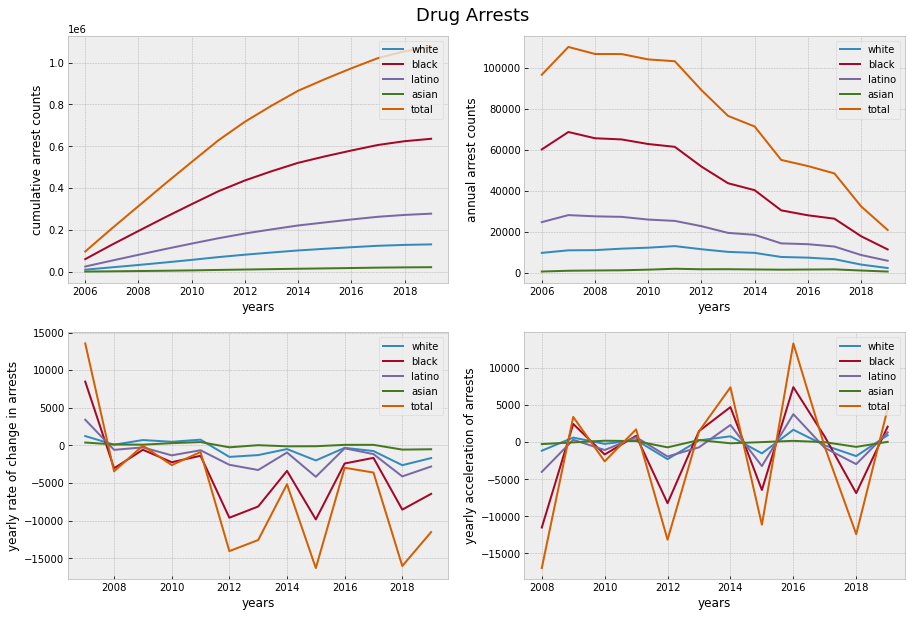

In [12]:
fig = plt.figure(figsize=(15,10))

trev = np.zeros(14)
wrev = np.zeros(14)
brev = np.zeros(14)
lrev = np.zeros(14)
arev = np.zeros(14)
#orev = np.zeros(14)

for i,j in enumerate(np.arange(2006,2020)):
    trev[i] = np.sum(years_drug[j][:,0])
    wrev[i] = np.sum(years_drug[j][:,1])
    brev[i] = np.sum(years_drug[j][:,2])
    lrev[i] = np.sum(years_drug[j][:,3])
    arev[i] = np.sum(years_drug[j][:,4])
    #orev[i] = np.sum(years_drug[j][:,5])
    
ax = fig.add_subplot(221)
plt.plot(np.arange(2006,2020),np.cumsum(wrev),label='white')
plt.plot(np.arange(2006,2020),np.cumsum(brev),label='black')
plt.plot(np.arange(2006,2020),np.cumsum(lrev),label='latino')
plt.plot(np.arange(2006,2020),np.cumsum(arev),label='asian')
plt.plot(np.arange(2006,2020),np.cumsum(trev),label='total')
#plt.plot(np.arange(2006,2020),orev,label='other')
plt.legend(loc=1)

ax.set_xlabel('years')
ax.set_ylabel('cumulative arrest counts')

ax = fig.add_subplot(222)
plt.plot(np.arange(2006,2020),wrev,label='white')
plt.plot(np.arange(2006,2020),brev,label='black')
plt.plot(np.arange(2006,2020),lrev,label='latino')
plt.plot(np.arange(2006,2020),arev,label='asian')
plt.plot(np.arange(2006,2020),trev,label='total')
#plt.plot(np.arange(2006,2020),np.cumsum(orev),label='other')

ax.set_xlabel('years')
ax.set_ylabel('annual arrest counts')
plt.legend(loc=1)

ax = fig.add_subplot(223)
plt.plot(np.arange(2007,2020),np.diff(wrev),label='white')
plt.plot(np.arange(2007,2020),np.diff(brev),label='black')
plt.plot(np.arange(2007,2020),np.diff(lrev),label='latino')
plt.plot(np.arange(2007,2020),np.diff(arev),label='asian')
plt.plot(np.arange(2007,2020),np.diff(trev),label='total')
#plt.plot(np.arange(2007,2020),np.diff(orev),label='other')

ax.set_xlabel('years')
ax.set_ylabel('yearly rate of change in arrests')
plt.legend(loc=1)

ax = fig.add_subplot(224)
plt.plot(np.arange(2008,2020),np.diff(wrev,2),label='white')
plt.plot(np.arange(2008,2020),np.diff(brev,2),label='black')
plt.plot(np.arange(2008,2020),np.diff(lrev,2),label='latino')
plt.plot(np.arange(2008,2020),np.diff(arev,2),label='asian')
plt.plot(np.arange(2008,2020),np.diff(trev,2),label='total')
#plt.plot(np.arange(2008,2020),np.diff(orev,2),label='other')

ax.set_xlabel('years')
ax.set_ylabel('yearly acceleration of arrests')
plt.legend(loc=1)

fig.suptitle('Drug Arrests',y=.92,fontsize=18)

yr = 365.25
arrest_rates = {}
for i,year in enumerate(np.arange(2006,2020)):
    arrest_rates[year] = np.array([wrev[i]/yr,brev[i]/yr,lrev[i]/yr,arev[i]/yr])

pass

In [13]:
arrest_rates

{2006: array([ 27.09377139, 165.18275154,  68.13689254,   2.19849418]),
 2007: array([ 30.49965777, 188.39425051,  77.48939083,   3.24435318]),
 2008: array([ 30.75701574, 180.06844627,  75.87132101,   3.59206023]),
 2009: array([ 32.7118412 , 178.48870637,  75.15126626,   3.86310746]),
 2010: array([ 34.03422313, 172.36413415,  71.53182752,   4.68172485]),
 2011: array([ 36.12867899, 168.59411362,  69.76865161,   5.90006845]),
 2012: array([ 31.94798084, 142.2696783 ,  62.71594798,   5.21013005]),
 2013: array([ 28.42984257, 120.03559206,  53.76317591,   5.29500342]),
 2014: array([ 27.09377139, 110.76796715,  51.17590691,   4.96646133]),
 2015: array([21.62080767, 83.8275154 , 39.75906913,  4.67077344]),
 2016: array([20.73100616, 77.24845996, 38.69952088,  4.87611225]),
 2017: array([18.68035592, 72.71457906, 35.54004107,  5.08418891]),
 2018: array([11.4825462 , 49.34976044, 24.26283368,  3.55646817]),
 2019: array([ 6.86926762, 31.71526352, 16.58042437,  2.15742642])}

In [14]:
warnings.simplefilter(action='ignore', category=UserWarning)

def make_plot1(race='Total'):
    ax = nyc.plot(race,missing_kwds= dict(color = "lightgrey",))
    ax.axis('off'); fig = plt.gcf()
    ax.set_title('NYC Residence 2010 Census (raw counts)')
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [np.nanmin(nyc[race]), np.nanmax(nyc[race])]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot1,race=["Total","White","Black","Latino","Asian","Others"])
pass

interactive(children=(Dropdown(description='race', options=('Total', 'White', 'Black', 'Latino', 'Asian', 'Oth…

In [15]:
warnings.simplefilter(action='ignore', category=UserWarning)

def make_plot2(race='White'):
    nyc['temp'] = nyc[race]/nyc['Total']
    ax = nyc.plot('temp',missing_kwds= dict(color = "lightgrey",))
    ax.axis('off'); fig = plt.gcf()
    ax.set_title('NYC Residence 2010 Census (proportions)')
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [0,1]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot2,race=["White","Black","Latino","Asian","Others"])
pass

interactive(children=(Dropdown(description='race', options=('White', 'Black', 'Latino', 'Asian', 'Others'), va…

In [16]:
warnings.simplefilter(action='ignore', category=UserWarning)

def make_plot3(year=2006,race='Total',crime='Drug'):
    dem = {'Total':0,'White':1,'Black':2,'Latino':3,'Asian':4,'Other':5}
    if crime=='Drug':
        nyc['temp']=years_drug[year][:,dem[race]]
    elif crime=='Loiter':
        nyc['temp']=years_loiter[year][:,dem[race]]
    ax = nyc.plot('temp',missing_kwds= dict(color = "lightgrey",))
    ax.axis('off'); fig = plt.gcf()
    ax.set_title('Racial ' + crime + ' Arrests (raw counts)')
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [np.nanmin(nyc['temp']), np.nanmax(nyc['temp'])]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot3, year=(2006, 2019, 1),race=["Total","White","Black","Latino","Asian","Other"],crime=['Drug','Loiter'])
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Dropdown(description='rac…

In [17]:
warnings.simplefilter(action='ignore', category=UserWarning)

def make_plot4(year=2006,race='White',crime='Drug'):
    dem = {'White':1,'Black':2,'Latino':3,'Asian':4,'Other':5}
    if crime=='Drug':
        nyc['temp']=years_drug[year][:,dem[race]]/years_drug[year][:,0]
    elif crime=='Loiter':
        nyc['temp']=years_loiter[year][:,dem[race]]/years_loiter[year][:,0]
    ax = nyc.plot('temp',missing_kwds= dict(color = "lightgrey",))
    ax.axis('off'); fig = plt.gcf()
    ax.set_title('Racial ' + crime +' Arrests (proportions)')
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [0,1]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot4, year=(2006, 2019, 1),race=["White","Black","Latino","Asian","Other"],crime=['Drug','Loiter'])
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Dropdown(description='rac…

In [18]:
warnings.simplefilter(action='ignore', category=UserWarning)

def make_plot5(year=2006,race='White',crime='Drug'):
    dem = {'White':1,'Black':2,'Latino':3,'Asian':4,'Other':5}
    vmin = 0
    vmax = 10
    if crime=='Drug':
        nyc['temp']=(years_drug[year][:,dem[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total'])
    elif crime=='Loiter':
        nyc['temp']=(years_loiter[year][:,dem[race]]/years_loiter[year][:,0])/(nyc[race]/nyc['Total'])
    ax = nyc.plot('temp',missing_kwds= dict(color = "lightgrey",),vmin=vmin,vmax=vmax)
    ax.axis('off'); fig = plt.gcf()
    temp = np.nanmean(nyc['temp'])
    ax.set_title('Racial '+ crime +' Arrests Scaled by Racial Residence\nmean: '+str(np.round(temp,2)))
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [vmin,vmax]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot5, year=(2006, 2019, 1),race=["White","Black","Latino","Asian"],crime=['Drug','Loiter'])
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Dropdown(description='rac…

show raw drug statistics

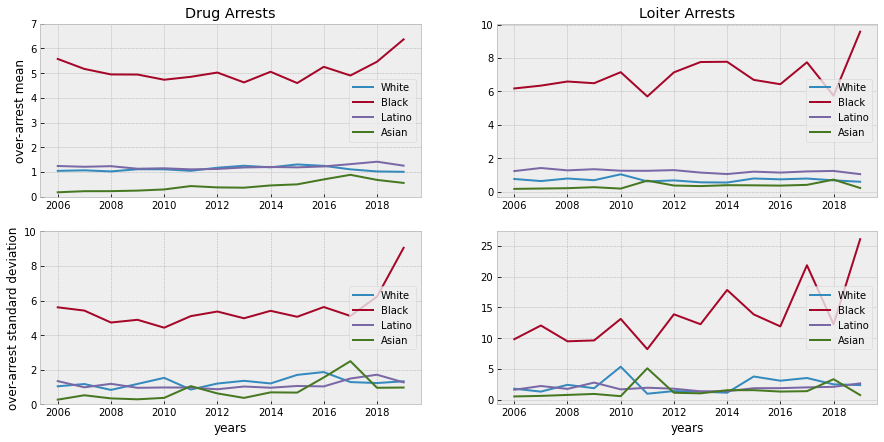

In [152]:
fig = plt.figure(figsize=(15,7))

drugMean = np.zeros([14,4])
loiterMean = np.zeros([14,4])
drugMedian = np.zeros([14,4])
loiterMedian = np.zeros([14,4])
drugErr = np.zeros([14,4])
loiterErr = np.zeros([14,4])
dem = {'White':1,'Black':2,'Latino':3,'Asian':4,'Other':5}
for i,year in enumerate(np.arange(2006,2020)):
    for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
        drugMean[i,j] = np.nanmean((years_drug[year][:,dem[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total']))
        drugMedian[i,j] = np.nanmedian((years_drug[year][:,dem[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total']))
        drugErr[i,j] = np.nanstd((years_drug[year][:,dem[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total']))
        loiterMean[i,j] = np.nanmean((years_loiter[year][:,dem[race]]/years_loiter[year][:,0])/(nyc[race]/nyc['Total']))
        loiterMedian[i,j] = np.nanmedian((years_loiter[year][:,dem[race]]/years_loiter[year][:,0])/(nyc[race]/nyc['Total']))
        loiterErr[i,j] = np.nanstd((years_loiter[year][:,dem[race]]/years_loiter[year][:,0])/(nyc[race]/nyc['Total']))
        
ax = fig.add_subplot(221)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugMean[:,j], label=race)
ax.set_title('Drug Arrests') 
plt.legend(loc=5)
ax.set_ylim([0,7])
ax.set_ylabel('over-arrest mean')
#ax.set_xlabel('years')

ax = fig.add_subplot(222)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),loiterMean[:,j], label=race)
ax.set_title('Loiter Arrests') 
plt.legend(loc=5)
#ax.set_ylabel('over-arrest mean')
#ax.set_xlabel('years')

#ax = fig.add_subplot(223)
#for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
#    ax.plot(np.arange(2006,2020),drugMedian[:,j], label=race)
#ax.set_title('Drug Arrests') 
#plt.legend(loc=5)
#ax.set_ylabel('over-arrest median')
#ax.set_xlabel('years')

#ax = fig.add_subplot(224)
#for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
#    ax.plot(np.arange(2006,2020),loiterMedian[:,j], label=race)
#ax.set_title('Loiter Arrests') 
#plt.legend(loc=5)
#ax.set_ylabel('over-arrest mean')
#ax.set_xlabel('years')


ax = fig.add_subplot(223)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugErr[:,j], label=race)
#ax.set_title('Drug Arrests') 
plt.legend(loc=5)
ax.set_ylim([0,10])
ax.set_ylabel('over-arrest standard deviation')
ax.set_xlabel('years')

ax = fig.add_subplot(224)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),loiterErr[:,j], label=race)
#ax.set_title('Loiter Arrests') 
plt.legend(loc=5)
#ax.set_ylabel('over-arrest variance')
ax.set_xlabel('years')

pass

In [121]:
warnings.simplefilter(action='ignore', category=UserWarning)
from scipy.optimize import curve_fit

# define our (line) fitting function\
def power_law(x, a, b):
    return a*np.power(x, b)

def make_plotHI(year=2006):
    x = np.zeros([len(nyc),4])
    y = np.zeros([len(nyc),4])
    for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
        y[:,j] = (years_drug[year][:,dem[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total'])
        x[:,j] = nyc[race]/nyc['Total']
        plt.plot(x[:,j],y[:,j],'o',label=race,markersize=8)
    col = ['blue', 'red', 'purple', 'green']
    keep = np.array(list(set(np.arange(0,len(nyc))[~np.isnan(x[:,j])]) and set(np.arange(0,len(nyc))[~np.isnan(y[:,j])])))
    #for j in range(4):
    #    pars, cov = curve_fit(f=power_law, xdata=x[keep,j], ydata=y[keep,j], 
    #                          p0=[50, -1], bounds=(-np.inf, np.inf))
    #    #plt.plot(x[keep,j], power_law(x[keep,j],pars[0],pars[1]),'.',color=col[j])
    plt.plot(np.arange(0,2),[1,1],color='k', label='representative policing')
    plt.legend()
    plt.yscale('log'); plt.xscale('log'); 
    plt.ylim([0,100]); plt.xlim([0,1])
    plt.xlabel('neighborhood demographics'); plt.ylabel('over-policing in that neighborhood')

# create widget
interact(make_plotHI, year=(2006, 2019, 1))
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Output()), _dom_classes=(…

[-0.45940935 -0.38401253 -0.71551014 -0.21338413]
[0.40253253 1.74130626 0.3205423  0.2252283 ]


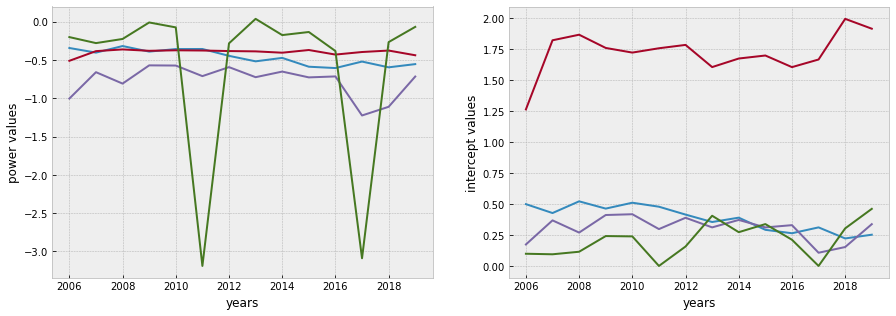

In [123]:
fig = plt.figure(figsize=(15,5))

intercept_vec = np.zeros([14,4])
power_vec = np.zeros([14,4])
for i,year in enumerate(np.arange(2006,2020)):
    for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
        y = (years_drug[year][:,dem[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total'])
        x = nyc[race]/nyc['Total']
        keep = np.array(list(set(np.arange(0,len(nyc))[~np.isnan(x)]) and set(np.arange(0,len(nyc))[~np.isnan(y)])))
        pars, cov = curve_fit(f=power_law, xdata=x[keep], ydata=y[keep],p0=[50, -1], bounds=(-np.inf, np.inf))
        intercept_vec[i,j] = pars[0]; power_vec[i,j] = pars[1]
            
ax = fig.add_subplot(121)
for i,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),power_vec[:,i],label=race)

ax.set_xlabel('years'); ax.set_ylabel('power values')
    
ax = fig.add_subplot(122)
for i,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),intercept_vec[:,i],label=race)
    
ax.set_xlabel('years'); ax.set_ylabel('intercept values')    


avg_power = np.median(power_vec,0)
avg_vec = np.median(intercept_vec,0)
print(avg_power)
print(avg_vec)

pass

In [28]:
warnings.simplefilter(action='ignore', category=UserWarning)

def make_plot7(year=2006):
    nyc['temp'] = years_violent[year]
    ax = nyc.plot('temp',missing_kwds= dict(color = "lightgrey",))
    ax.axis('off'); fig = plt.gcf()
    ax.set_title('Violent Crimes')
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [np.nanmin(nyc['temp']),np.nanmax(nyc['temp'])]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot7, year=(2006, 2019, 1))
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Output()), _dom_classes=(…

In [130]:
ncops = 36600
race_prop = np.transpose(np.array([nyc['White'], nyc['Black'], nyc['Latino'], nyc['Asian']])/np.array(nyc['Total']))
BWmat = np.zeros([4,4])
for i in range(4):
    BWmat[i,i] = 1

def RK(year, arrest, intercept, power, Tt=365.25):
    # define differential policing per neighborhood
    #cops = np.round(ncops*years_violent[year]/np.sum(years_violent[year]))
    dxdt = np.zeros([len(nyc),4])
    for i in range(4): # arrest of different racial groups
        for j in range(4): # BW bias dependent on neighborhood demographcics
            dxdt[:,i] += power_law(race_prop[:,i],intercept[i,j],power)
        #dxdt[:,i] *= cops
    dxdt = arrest*dxdt
    return dxdt*Tt


def calc_residuals(year,sim):
    data = years_drug[year][:,1:5]
    data_scale = (data/np.transpose(np.matrix(np.sum(data,1))))/race_prop
    sim_scale = (sim/np.transpose(np.matrix(np.sum(sim,1))))/race_prop
    return np.sqrt(np.nansum(np.power(data_scale-sim_scale,2)))

In [131]:
#warnings.simplefilter(action='ignore', category=UserWarning)

def make_plot8(year=2006,race='White'):
    sim = RK(year,arrest_rates[year],BWmat,1)
    dem = {'White':0,'Black':1,'Latino':2,'Asian':3}
    vmin = 0
    vmax = 10
    nyc['temp'] = (sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total'])
    ax = nyc.plot('temp',missing_kwds= dict(color = "lightgrey",),vmin=vmin,vmax=vmax)
    ax.axis('off'); fig = plt.gcf()
    ax.set_title('Simulated Drug Arrests with Implicit Bias Policing\nmean: '+str(np.round(np.nanmean(nyc['temp']),2)))
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [vmin,vmax]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot8, year=(2006, 2019, 1), race=['White','Black','Latino','Asian'])
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Dropdown(description='rac…

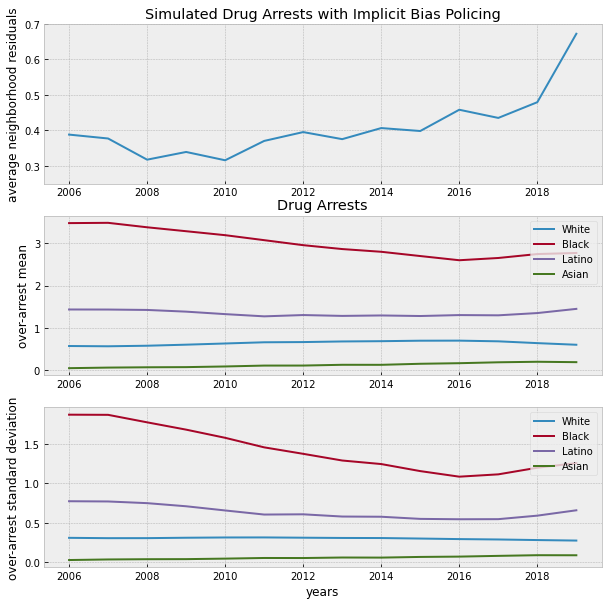

In [132]:
fig = plt.figure(figsize=(10,10))

drugMean = np.zeros([14,4])
drugMedian = np.zeros([14,4])
drugErr = np.zeros([14,4])
res = np.zeros(14)
dem = {'White':0,'Black':1,'Latino':2,'Asian':3}
for i,year in enumerate(np.arange(2006,2020)):
    sim = RK(year,arrest_rates[year],BWmat,1)
    res[i] = calc_residuals(year,sim)
    for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
        drugMean[i,j] = np.nanmean((sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total']))
        drugMedian[i,j] = np.nanmedian((sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total']))
        drugErr[i,j] = np.nanstd((sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total']))
    
ax = fig.add_subplot(311)
ax.plot(np.arange(2006,2020),res/len(nyc))
ax.set_title('Simulated Drug Arrests with Implicit Bias Policing') 
ax.set_ylabel('average neighborhood residuals')
#ax.set_xlabel('years') 
ax.set_ylim([.25,.7])
    
ax = fig.add_subplot(312)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugMean[:,j], label=race)
ax.set_title('Drug Arrests') 
#ax.set_ylim([0,7])
plt.legend(loc=0)
ax.set_ylabel('over-arrest mean')
#ax.set_xlabel('years')

ax = fig.add_subplot(313)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugErr[:,j], label=race)
#ax.set_title('Drug Arrests') 
#ax.set_ylim([0,10])
plt.legend(loc=0)
ax.set_ylabel('over-arrest standard deviation')
ax.set_xlabel('years')


pass

In [141]:
# fitting procedure
def fit(year,N=int(1e3),T0=5,tau=5000.0,offset=1e-2,xmax=5,power=0.5):
    arrest = np.mean(arrest_rates[year])
    T = T0
    # initialize for the MCMC
    nparams=16
    BW = np.transpose(np.vstack([intercept_vec[year-2006,:],intercept_vec[year-2006,:],intercept_vec[year-2006,:],intercept_vec[year-2006,:]]))
    for i in range(4):
        BW[i,i] = 1
    BW_vec = np.zeros(nparams*N).reshape([N, 4, 4])
    res_vec = np.zeros(N)
    # sim
    sim = RK(year, arrest, BW, power=power)
    res = calc_residuals(year,sim)
    # iterate with MCMC
    for i in range(N):
        rot =  np.unravel_index(i % nparams, BW.shape, 'F')
        x = BW[rot]
        # proposal
        BW0 = 1.0*BW
        x0 = xmax+1
        while x0 > xmax:
            x0 = stats.gamma.rvs(x+offset)
        BW0[rot] = x0
        # simulate
        sim0 =  RK(year, arrest, BW0, power=power)
        # assess the proposed new parameter
        res0 = calc_residuals(year,sim0)
        ratio = np.exp(-(res0 - res)/(T))
        # M-H criterion
        if np.abs(ratio) > np.random.rand():
            # accept
            BW = 1.0*BW0[:]
            # update sim
            sim = sim0
            # update params
            res = res0
        # cool system
        T = T0*np.exp(-1.0*i/tau)
        BW_vec[i,:,:] = BW
        res_vec[i] = res
    print(year)
    return BW_vec, res_vec

In [143]:
years_BWa = {}; years_BWm = {}
years_res = {}

N=int(2e5)
power = 0.5
for year in np.arange(2006,2020):
    BW, res = fit(year,N=N,tau=N/2,T0=2,xmax=1,power=power)
    BW = BW[int(N/2):]; res = res[int(N/2):]
    years_BWm[year] = np.median(BW,0); years_BWa[year] = np.mean(BW,0)
    years_res[year] = np.median(res)
    
print('done')

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
done


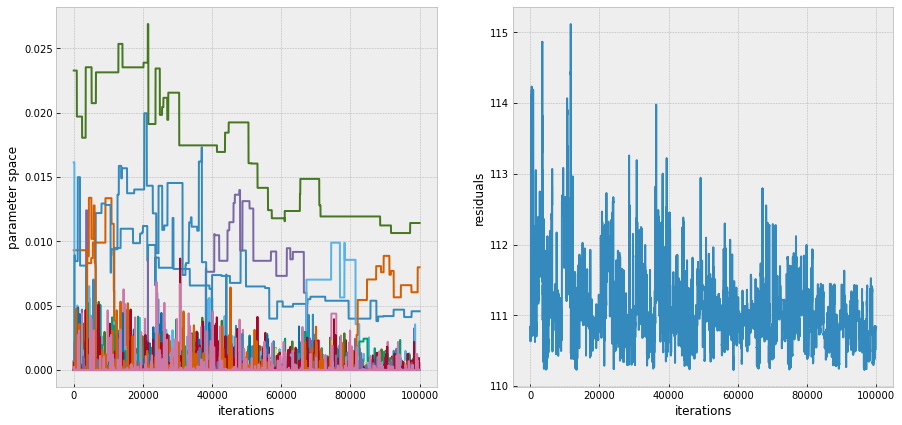

In [144]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

key = ['white/white', 'white/black', 'white/latino', 'white/asian',
       'black/white', 'black/black', 'black/latino', 'black/asian',
       'latino/white', 'latino/black', 'latino/latino', 'latino/asian',
       'asian/white', 'asian/black', 'asian/latino', 'asian/asian']

for i in range(4):
    ax1.plot(BW[:,:,i])
#ax1.legend(key)
ax2.plot(res)

ax1.set_xlabel('iterations')
ax1.set_ylabel('parameter space')

ax2.set_xlabel('iterations')
ax2.set_ylabel('residuals')

pass

In [145]:
def make_plot9(year=2006,race='White'):
    arrest = np.mean(arrest_rates[year])
    BW = years_BWa[year]
    sim = RK(year, arrest,BW, power)
    dem = {'White':0,'Black':1,'Latino':2,'Asian':3}
    vmin = 0
    vmax = 10
    nyc['temp'] = (sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total'])
    ax = nyc.plot('temp',missing_kwds= dict(color = "lightgrey",),vmin=vmin,vmax=vmax)
    ax.axis('off'); fig = plt.gcf()
    ax.set_title('Simulated Drug Arrests with Broken Windows Policing\nmean: '+str(np.round(np.nanmean(nyc['temp']),3)))
    cax = fig.add_axes([0.9, 0.2, 0.025, 0.65])
    sm = plt.cm.ScalarMappable()
    sm._A = [vmin,vmax]
    fig.colorbar(sm, cax=cax)


# create widget
interact(make_plot9, year=(2006, 2019, 1), race=['White','Black','Latino','Asian'])
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Dropdown(description='rac…

In [150]:
def make_plot10(year=2006):
    BW = years_BWa[year]*1.0
    for i in range(4):
        for j in range(4):
            plt.text(j,i, np.round(BW[i,j],4),color='black',
                     bbox={'facecolor': 'white', 'alpha': 0.75, 'pad': 10},fontsize=14)
    # set diagonals to null
    for i in range(4):
        BW[i,i] = np.nan
    plt.imshow(BW,vmax=0.001,norm=LogNorm())
    plt.colorbar(label='over-policing')#,fontsize=14)
    plt.title('Broken Windows Policing Fitted Parameters',fontsize=14)
    plt.yticks(np.arange(0,4), ['White', 'Black', 'Latino', 'Asian'],fontsize=12)
    plt.ylabel('Arrests',fontsize=14)
    plt.xticks(np.arange(0,4), ['White', 'Black', 'Latino', 'Asian'],fontsize=12)
    plt.xlabel('Neighborhood Demographics',fontsize=14)


# create widget
interact(make_plot10, year=(2006, 2019, 1))
pass

interactive(children=(IntSlider(value=2006, description='year', max=2019, min=2006), Output()), _dom_classes=(…

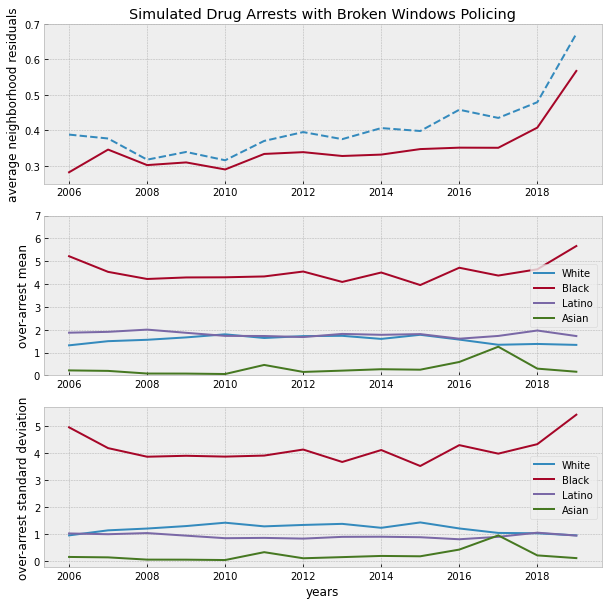

In [158]:
fig = plt.figure(figsize=(10,10))

drugMean = np.zeros([14,4])
drugMedian = np.zeros([14,4])
drugErr = np.zeros([14,4])
res = np.zeros(14)
res0 = np.zeros(14)
dem = {'White':0,'Black':1,'Latino':2,'Asian':3}
for i,year in enumerate(np.arange(2006,2020)):
    arrest = np.mean(arrest_rates[year])
    #BW = np.transpose(np.vstack([intercept_vec[year-2006,:],intercept_vec[year-2006,:],intercept_vec[year-2006,:],intercept_vec[year-2006,:]]))
    BW = years_BWa[year]
    sim = RK(year, arrest, BW, power)
    res[i] = calc_residuals(year,sim)
    res0[i] = calc_residuals(year,RK(year, arrest_rates[year], BWmat, 1))
    for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
        drugMean[i,j] = np.nanmean((sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total']))
        drugMedian[i,j] = np.nanmedian((sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total']))
        drugErr[i,j] = np.nanstd((sim[:,dem[race]]/np.sum(sim,1))/(nyc[race]/nyc['Total']))
        
ax = fig.add_subplot(311)
ax.plot(np.arange(2006,2020),res0/len(nyc),'--')
ax.plot(np.arange(2006,2020),res/len(nyc))
#ax.plot(np.arange(2006,2020),gof/len(nyc))#,label='model goodness of fit from MCMC')
#plt.legend(loc=5)
ax.set_title('Simulated Drug Arrests with Broken Windows Policing') 
ax.set_ylabel('average neighborhood residuals')
#ax.set_xlabel('years') 
ax.set_ylim([.25,.7])      
    
ax = fig.add_subplot(312)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugMean[:,j], label=race) 
plt.legend(loc=5)
ax.set_ylabel('over-arrest mean')
ax.set_ylim([0,7])
#ax.set_xlabel('years')

ax = fig.add_subplot(313)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugErr[:,j], label=race)
#ax.set_title('Drug Arrests') 
plt.legend(loc=5)
ax.set_ylabel('over-arrest standard deviation')
ax.set_xlabel('years')

pass

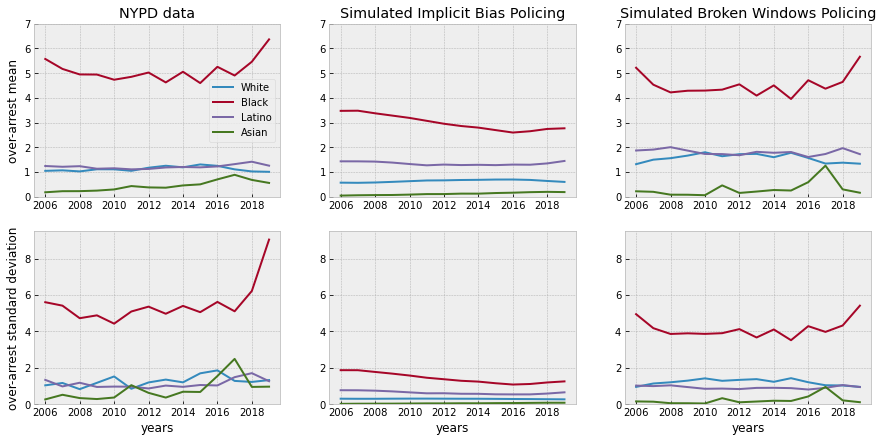

In [156]:
# altogether 
fig = plt.figure(figsize=(15,7))

drugData = np.zeros([14,4])
drugErrD = np.zeros([14,4])
drugSim1 = np.zeros([14,4])
drugSim2 = np.zeros([14,4])
drugErr1 = np.zeros([14,4])
drugErr2 = np.zeros([14,4])
#res1 = np.zeros([14,4])
#res2 = np.zeros([14,4])
dem1 = {'White':0,'Black':1,'Latino':2,'Asian':3}
dem0 = {'White':1,'Black':2,'Latino':3,'Asian':4}
for i,year in enumerate(np.arange(2006,2020)):
    arrest = np.mean(arrest_rates[year])
    BW = years_BWa[year]
    sim1 = RK(year, arrest_rates[year], BWmat,1)
    sim2 = RK(year, arrest, BW, power)
    #res1[i] = calc_residuals(year,sim1)
    #res2[i] = calc_residuals(year,sim2)
    for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
        drugSim1[i,j] = np.nanmean((sim1[:,dem1[race]]/np.sum(sim1,1))/(nyc[race]/nyc['Total']))
        drugSim2[i,j] = np.nanmean((sim2[:,dem1[race]]/np.sum(sim2,1))/(nyc[race]/nyc['Total']))
        drugErr1[i,j] = np.nanstd((sim1[:,dem1[race]]/np.sum(sim1,1))/(nyc[race]/nyc['Total']))
        drugErr2[i,j] = np.nanstd((sim2[:,dem1[race]]/np.sum(sim2,1))/(nyc[race]/nyc['Total']))
        drugData[i,j] = np.nanmean((years_drug[year][:,dem0[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total']))
        drugErrD[i,j] = np.nanstd((years_drug[year][:,dem0[race]]/years_drug[year][:,0])/(nyc[race]/nyc['Total']))

             
    
ax = fig.add_subplot(231)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugData[:,j], label=race) 
plt.legend(loc=5)
ax.set_ylabel('over-arrest mean')
#ax.set_ylim([0,7])
#ax.set_xlabel('years')
ax.set_title('NYPD data')
ax.set_ylim([0,7])

ax = fig.add_subplot(232)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugSim1[:,j], label=race) 
#plt.legend(loc=5)
#ax.set_ylabel('over-arrest mean')
#ax.set_xlabel('years')
ax.set_ylim([0,7])
ax.set_title('Simulated Implicit Bias Policing')

ax = fig.add_subplot(233)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugSim2[:,j], label=race) 
#plt.legend(loc=5)
#ax.set_ylabel('over-arrest mean')
#ax.set_xlabel('years')
ax.set_ylim([0,7])
ax.set_title('Simulated Broken Windows Policing')

ax = fig.add_subplot(234)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugErrD[:,j], label=race)
#ax.set_title('Drug Arrests') 
#plt.legend(loc=5)
ax.set_ylabel('over-arrest standard deviation')
ax.set_xlabel('years')
ax.set_ylim([0,9.5])

ax = fig.add_subplot(235)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugErr1[:,j], label=race)
#ax.set_title('Drug Arrests') 
#plt.legend(loc=5)
#ax.set_ylabel('over-arrest standard deviation')
ax.set_xlabel('years')
ax.set_ylim([0,9.5])

ax = fig.add_subplot(236)
for j,race in enumerate(['White', "Black", "Latino", "Asian"]):
    ax.plot(np.arange(2006,2020),drugErr2[:,j], label=race)
#ax.set_title('Drug Arrests') 
#plt.legend(loc=5)
#ax.set_ylabel('over-arrest standard deviation')
ax.set_xlabel('years')
ax.set_ylim([0,9.5])


pass